In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read the file
data = pd.read_csv('../artifacts/CVEFixes.csv/CVEFixes.csv')

In [3]:
data.head()

,code,language,safety
0,package org.bouncycastle.jcajce.provider.asymm...,java,vulnerable
1,<?php\n\n\n\n/**\n\n * ownCloud - user_ldap\n\...,php,vulnerable
2,#!/usr/bin/env python\n\nfrom __future__ impor...,py,safe
3,/* -*- c-basic-offset: 8 -*-\n\n rdesktop: A...,c,safe
4,<!DOCTYPE html>\n\n<html>\n\n <head>\n\n ...,html,safe


# Data Preprocessing

In [4]:
data.shape

(31194, 3)

In [5]:
#finding duplicate raws
data.duplicated().sum()

np.int64(6471)

In [6]:
# Drop all duplicate rows and keep only the first occurrence
data = data.drop_duplicates()


In [7]:
# Confirm that there are no duplicates left
print(f"Remaining duplicates: {data.duplicated().sum()}")


Remaining duplicates: 0


In [8]:
data.duplicated().sum()

np.int64(0)

In [9]:
#finding null values
data.isnull().sum()

code        6
language    0
safety      0
dtype: int64

In [10]:
#Replace null (NaN) values in the 'code' column with 0
data.loc[:, 'code'] = data['code'].fillna(0)

In [11]:
data.isnull().sum()

code        0
language    0
safety      0
dtype: int64

## Preprocessing Code

In [12]:
import re
import string

In [13]:
data.head(5)

,code,language,safety
0,package org.bouncycastle.jcajce.provider.asymm...,java,vulnerable
1,<?php\n\n\n\n/**\n\n * ownCloud - user_ldap\n\...,php,vulnerable
2,#!/usr/bin/env python\n\nfrom __future__ impor...,py,safe
3,/* -*- c-basic-offset: 8 -*-\n\n rdesktop: A...,c,safe
4,<!DOCTYPE html>\n\n<html>\n\n <head>\n\n ...,html,safe


In [14]:
def preprocess_code(code):
    # Ensure the input is treated as a string
    code = str(code)
    
    # 1. Remove comments (for Java, PHP, Python, etc.)
    code = re.sub(r'//.*|/\*.*?\*/', ' ', code, flags=re.DOTALL)  # Remove single and multi-line comments
    
    # 2. Remove extra whitespace and newline characters
    code = re.sub(r'\s+', ' ', code)  # Replace multiple spaces and newlines with a single space
    
    # 3. Remove special characters (e.g., HTML tags)
    code = re.sub(r'<.*?>', ' ', code)  # Remove HTML tags
    
    # 4. Remove unnecessary keywords or symbols (optional)
    code = re.sub(r'\b(?:package|import|public|class|function|php|\?>)\b', ' ', code)  # Updated to avoid `<?php`
    
    # 5. Normalize to lowercase (optional)
    code = code.lower()
    
    return code.strip()


In [15]:
data['preprocess_code'] = data['code'].apply(preprocess_code)

In [16]:
# Apply the preprocess_code function to clean the 'code' column in place
data['code'] = data['code'].apply(preprocess_code)


In [17]:
data.head(5)

,code,language,safety,preprocess_code
0,org.bouncycastle.jcajce.provider.asymmetric.ds...,java,vulnerable,org.bouncycastle.jcajce.provider.asymmetric.ds...
1,"<? $params = array('ldap_host', 'ldap_port', ...",php,vulnerable,"<? $params = array('ldap_host', 'ldap_port', ..."
2,#!/usr/bin/env python from __future__ divisi...,py,safe,#!/usr/bin/env python from __future__ divisi...
3,"#include ""rdesktop.h"" #define cliprdr_connect ...",c,safe,"#include ""rdesktop.h"" #define cliprdr_connect ..."
4,vnc performance benchmark passes: &nbsp;...,html,safe,vnc performance benchmark passes: &nbsp;...


In [18]:
# Add a new feature for code length
data['code_length'] = data['code'].apply(len)

In [19]:
# Count number of function calls in the code (e.g., occurrences of function names)
data['function_calls'] = data['code'].apply(lambda x: len(re.findall(r'\b\w+\b', x)))  # Adjust regex as needed


In [20]:
# Define a list of vulnerability keywords
vulnerability_keywords = ['eval', 'exec', 'system', 'shell', 'open', 'eval']

# Count the occurrence of vulnerability keywords in each code snippet
data['vuln_keywords'] = data['code'].apply(lambda x: sum([x.count(kw) for kw in vulnerability_keywords]))


After preprocessing, finaal dataset 

In [21]:
data


,code,language,safety,preprocess_code,code_length,function_calls,vuln_keywords
0,org.bouncycastle.jcajce.provider.asymmetric.ds...,java,vulnerable,org.bouncycastle.jcajce.provider.asymmetric.ds...,2285,211,0
1,"<? $params = array('ldap_host', 'ldap_port', ...",php,vulnerable,"<? $params = array('ldap_host', 'ldap_port', ...",1039,87,0
2,#!/usr/bin/env python from __future__ divisi...,py,safe,#!/usr/bin/env python from __future__ divisi...,937,125,5
3,"#include ""rdesktop.h"" #define cliprdr_connect ...",c,safe,"#include ""rdesktop.h"" #define cliprdr_connect ...",3627,343,0
4,vnc performance benchmark passes: &nbsp;...,html,safe,vnc performance benchmark passes: &nbsp;...,174,17,0
...,...,...,...,...,...,...,...
31187,#ifndef archive_h_included #define archive_h_i...,h,safe,#ifndef archive_h_included #define archive_h_i...,26926,2276,29
31188,#ifndef iscsi_parameters_h #define iscsi_param...,h,vulnerable,#ifndef iscsi_parameters_h #define iscsi_param...,9064,828,0
31189,spark.resource; java.io.filenotfoundexceptio...,java,safe,spark.resource; java.io.filenotfoundexceptio...,3148,348,1
31191,_isenabled = true; $this->_isajax = false; $th...,Other,safe,_isenabled = true; $this->_isajax = false; $th...,447,47,0


### Checking Safety Column Balance/Imbalance

In [22]:
# Check the class distribution
print(data['safety'].value_counts())


safety
safe          12904
vulnerable    11819
Name: count, dtype: int64


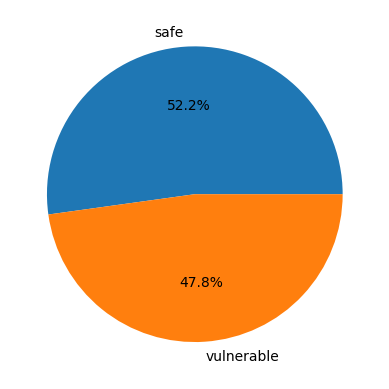

In [23]:
# Count the occurrences of each class in 'safety'
class_counts = data['safety'].value_counts()

#plot the pie chart
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.show()

In [24]:
# Encoding 'safe' as 0 and 'vulnerable' as 1
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['safety_encoded'] = encoder.fit_transform(data['safety'])

# Display the first few rows to verify
print(data[['safety', 'safety_encoded']].head())


       safety  safety_encoded
0  vulnerable               1
1  vulnerable               1
2        safe               0
3        safe               0
4        safe               0


In [25]:
data.head()

,code,language,safety,preprocess_code,code_length,function_calls,vuln_keywords,safety_encoded
0,org.bouncycastle.jcajce.provider.asymmetric.ds...,java,vulnerable,org.bouncycastle.jcajce.provider.asymmetric.ds...,2285,211,0,1
1,"<? $params = array('ldap_host', 'ldap_port', ...",php,vulnerable,"<? $params = array('ldap_host', 'ldap_port', ...",1039,87,0,1
2,#!/usr/bin/env python from __future__ divisi...,py,safe,#!/usr/bin/env python from __future__ divisi...,937,125,5,0
3,"#include ""rdesktop.h"" #define cliprdr_connect ...",c,safe,"#include ""rdesktop.h"" #define cliprdr_connect ...",3627,343,0,0
4,vnc performance benchmark passes: &nbsp;...,html,safe,vnc performance benchmark passes: &nbsp;...,174,17,0,0


Preparing  Data

In [26]:
from sklearn.model_selection import train_test_split


In [27]:
# Display the first few rows of your data to check the structure
print(data.head())


                                                code language      safety  \
0  org.bouncycastle.jcajce.provider.asymmetric.ds...     java  vulnerable   
1  <?  $params = array('ldap_host', 'ldap_port', ...      php  vulnerable   
2  #!/usr/bin/env python from __future__   divisi...       py        safe   
3  #include "rdesktop.h" #define cliprdr_connect ...        c        safe   
4  vnc performance benchmark      passes:  &nbsp;...     html        safe   

                                     preprocess_code  code_length  \
0  org.bouncycastle.jcajce.provider.asymmetric.ds...         2285   
1  <?  $params = array('ldap_host', 'ldap_port', ...         1039   
2  #!/usr/bin/env python from __future__   divisi...          937   
3  #include "rdesktop.h" #define cliprdr_connect ...         3627   
4  vnc performance benchmark      passes:  &nbsp;...          174   

   function_calls  vuln_keywords  safety_encoded  
0             211              0               1  
1              87   

In [28]:
# Separate the features (X) from the target (y)
X = data.drop(columns=['safety']) #drop the target column 'safety' from the feature set
y = data['safety_encoded'].map({'safe': 0, 'vulnerable': 1})  # Ensures it stays 0/1



In [29]:
# Replace 'safe' with 0 and 'vulnerable' with 1
y = y.map({'safe': 0, 'vulnerable': 1})


In [30]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shape (X_test, y_test):", X_test.shape, y_test.shape)


Training set shape (X_train, y_train): (19778, 7) (19778,)
Testing set shape (X_test, y_test): (4945, 7) (4945,)


# Model Training & Evaluation

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Define function for training scores
def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    fl = round(f1_score(y_act, y_pred), 3)
    print(f'Training Scores: \n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {fl}')

def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred), 3)
    rec= round(recall_score(y_act, y_pred), 3)
    f1= round(f1_score(y_act, y_pred), 3)
    print(f'Testing Scores: \n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # You can change this number

# Fit and transform the 'code' column
X = vectorizer.fit_transform(data['code'])

# Use the already encoded labels
y = data['safety_encoded']  # If already encoded to 0 and 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)

# Evaluation
training_scores(y_train, lr.predict(X_train))
validation_scores(y_test, y_pred_lr)


Training Scores: 
	Accuracy = 0.568
	Precision = 0.571
	Recall = 0.389
	F1-Score = 0.463
Testing Scores: 
	Accuracy = 0.367
	Precision = 0.269
	Recall = 0.187
	F1-Score = 0.221


### Naive Bayes

In [36]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

training_scores(y_train, nb.predict(X_train))
validation_scores(y_test, y_pred_nb)


Training Scores: 
	Accuracy = 0.547
	Precision = 0.553
	Recall = 0.278
	F1-Score = 0.37
Testing Scores: 
	Accuracy = 0.428
	Precision = 0.305
	Recall = 0.153
	F1-Score = 0.204


### Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

training_scores(y_train, dt.predict(X_train))
validation_scores(y_test, y_pred_dt)


Training Scores: 
	Accuracy = 0.761
	Precision = 0.927
	Recall = 0.542
	F1-Score = 0.684
Testing Scores: 
	Accuracy = 0.252
	Precision = 0.153
	Recall = 0.124
	F1-Score = 0.137


### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)  # Use all cores available
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

training_scores(y_train, rf.predict(X_train))
validation_scores(y_test, y_pred_rf)


Training Scores: 
	Accuracy = 0.761
	Precision = 0.791
	Recall = 0.679
	F1-Score = 0.731
Testing Scores: 
	Accuracy = 0.225
	Precision = 0.128
	Recall = 0.106
	F1-Score = 0.116


### Support Vector Classifier

## Save Model: Naive Bayes

Save Naive Bayes model using pickle

In [39]:
import pickle

with open('../static/model/model.pickle', 'wb') as file:
    pickle.dump(nb, file)